**IMPORT**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
FILE = 'C:\\Users\\13719\\Desktop\\DGA\\artifacts\\binary\\dga_binary.csv'
df = pd.read_csv(FILE)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)
df.head()

In [ ]:
import seaborn as sns
sns.countplot(df[df['Botnet_Family']!='alexa']['Botnet_Family'])

In [ ]:
df['Target'].value_counts()

**BINARY CLASSIFIFCATION USING ML**

---



In [ ]:
df = df[['Domain', 'Target']]
df.head()

**FEATURE ENGINEERING**

**1) CUSTOM FEATURES EXTRACTION**

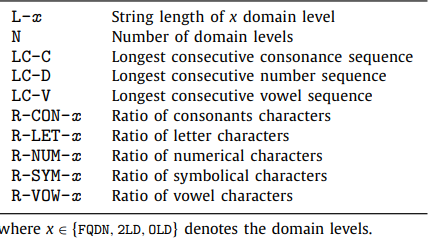

In [9]:
import re

def count_features(domain):
    # Length of domain_level
    L = len(domain)

    # Ratio of consonant characters
    consonant_count = sum(1 for char in domain if char in 'bcdfghjklmnpqrstvwxyz')
    Rc = consonant_count / len(domain) if len(domain) > 0 else 0

    # Ratio of letter characters
    letter_count = sum(1 for char in domain if char.isalpha())
    Rl = letter_count / len(domain) if len(domain) > 0 else 0

    # Ratio of numerical characters
    number_count = sum(1 for char in domain if char.isdigit())
    Rn = number_count / len(domain) if len(domain) > 0 else 0

    # Ratio of vowel characters
    vowel_count = sum(1 for char in domain if char in 'aeiou')
    Rv = vowel_count / len(domain) if len(domain) > 0 else 0

    # Ratio of symbolic characters
    symbolic_count = sum(1 for char in domain if not char.isalnum())
    Rs = symbolic_count / len(domain) if len(domain) > 0 else 0

    return L, Rc, Rv, Rn, Rl, Rs

# Calculate the domain-related features
def calculate_features(df):
    features = []

    for domain in df['Domain']:
      parts = domain.split('.')
      subdomain = '.'.join(parts[:-2]) if len(parts) >= 3 else '' # Subdomains
      sld = parts[-2] # Second level domain
      tld = parts[-1] # Top level domain

      # Number of domain levels
      N = 3 if subdomain else 2

      # Longest consecutive consonance sequence
      consonants = re.findall(r'[^aeiou\d\s\W]+', domain)
      LCc = max(len(consonant) for consonant in consonants) if consonants else 0

      # Longest consecutive number sequence
      numbers = re.findall(r'\d+', domain)
      LCn = max(len(number) for number in numbers) if numbers else 0

      # Longest consecutive vowel sequence
      vowels = re.findall(r'[aeiou]+', domain)
      LCv = max(len(vowel) for vowel in vowels) if vowels else 0

      # Features from each domain level
      L_tld, Rc_tld, Rv_tld, Rn_tld, Rl_tld, Rs_tld = count_features(tld)
      L_sld, Rc_sld, Rv_sld, Rn_sld, Rl_sld, Rs_sld = count_features(sld)
      L_sub, Rc_sub, Rv_sub, Rn_sub, Rl_sub, Rs_sub = count_features(subdomain) if subdomain else (0, 0, 0, 0, 0, 0)

      features.append([N, LCc, LCv, LCn, L_tld, Rc_tld, Rv_tld, Rn_tld, Rl_tld,Rs_tld, L_sld, Rc_sld, Rv_sld, Rn_sld, Rl_sld,Rs_sld, L_sub, Rc_sub, Rv_sub, Rn_sub, Rl_sub, Rs_sub])

    # Create a DataFrame with the features
    feature_columns = ['N', 'LCc', 'LCv', 'LCn',
                       'L_tld', 'Rc_tld', 'Rv_tld', 'Rn_tld', 'Rl_tld','Rs_tld',
                       'L_sld', 'Rc_sld', 'Rv_sld', 'Rn_sld', 'Rl_sld','Rs_sld',
                       'L_sub', 'Rc_sub', 'Rv_sub', 'Rn_sub', 'Rl_sub', 'Rs_sub']

    feature_df = pd.DataFrame(features, columns=feature_columns)

    # Concatenate with original dataframe
    return pd.concat([df, feature_df], axis=1)

In [ ]:
df_custom_features=calculate_features(df)
df_custom_features.head()

**2) N-GRAM FEATURE EXTRACTION**

* nG-DIST: Number of distinct n-grams with non-zero frequencies
* nG-MEAN: Average frequency of n-grams.
* nG-QMEAN: Quadratic mean (root mean square) of the n-gram frequencies.
* nG-SUMSQ: Sum of the squares of n-gram frequencies.
* nG-VAR: Sample variance of the n-gram frequencies.
* nG-PVAR: Population variance of the n-gram frequencies.
* nG-STD: Sample standard deviation of the n-gram frequencies.
* nG-PSTD: Population standard deviation of the n-gram frequencies.
* nG-SKE: Skewness, indicating the asymmetry of the n-gram frequency distribution.
* nG-KUR: Kurtosis, indicating the "tailedness" of the n-gram frequency distribution.
* **nG = {unigram, bigram, trigram}**

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import hstack

# Extract bigrams and trigrams using TF-IDF
unigrams = TfidfVectorizer(analyzer='char', ngram_range=(1, 1))
bigrams = TfidfVectorizer(analyzer='char', ngram_range=(2, 2))
trigrams = TfidfVectorizer(analyzer='char', ngram_range=(3, 3))

unigrams_matrix = unigrams.fit_transform(df['Domain'])
bigrams_matrix = bigrams.fit_transform(df['Domain'])
trigrams_matrix = trigrams.fit_transform(df['Domain'])

In [13]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis

def ngrams_features_per_sample(matrix, prefix):
    # Convert sparse matrix to dense
    ngram_frequencies = matrix.toarray()

    # Initialize a list to store feature dictionaries
    features_list = []

    # Loop through each sample
    for sample_frequencies in ngram_frequencies:
        features = {}

        # Count distinct n-grams (non-zero frequencies)
        if np.count_nonzero(sample_frequencies) > 0:  # Avoid NaN errors if no n-grams are present
            # Number of distinct n-grams (non-zero frequencies)
            features[f'{prefix}-DIST'] = np.count_nonzero(sample_frequencies)

            features[f'{prefix}-MEAN'] = np.mean(sample_frequencies)
            features[f'{prefix}-QMEAN'] = np.sqrt(np.mean(sample_frequencies**2))  # Quadratic mean
            features[f'{prefix}-SUMSQ'] = np.sum(sample_frequencies**2)  # Squared sum of frequencies
            features[f'{prefix}-VAR'] = np.var(sample_frequencies)
            features[f'{prefix}-PVAR'] = np.var(sample_frequencies, ddof=0)  # Population variance
            features[f'{prefix}-STD'] = np.std(sample_frequencies)
            features[f'{prefix}-PSTD'] = np.std(sample_frequencies, ddof=0)  # Population std deviation
            features[f'{prefix}-SKE'] = skew(sample_frequencies)
            features[f'{prefix}-KUR'] = kurtosis(sample_frequencies)
        else:
            features[f'{prefix}-DIST'] = 0
            features[f'{prefix}-MEAN'] = 0
            features[f'{prefix}-QMEAN'] = 0
            features[f'{prefix}-SUMSQ'] = 0
            features[f'{prefix}-VAR'] = 0
            features[f'{prefix}-PVAR'] = 0
            features[f'{prefix}-STD'] = 0
            features[f'{prefix}-PSTD'] = 0
            features[f'{prefix}-SKE'] = 0  # Skewness is 0 for no data
            features[f'{prefix}-KUR'] = 0  # Kurtosis is 0 for no data

        # Append features for this sample to the list
        features_list.append(features)

    # Convert the list of feature dictionaries into a DataFrame
    return pd.DataFrame(features_list)

In [ ]:
# Extract features
unigrams_features_df = ngrams_features_per_sample(unigrams_matrix, prefix='UNI')
bigrams_features_df = ngrams_features_per_sample(bigrams_matrix, prefix='BI')
trigrams_features_df = ngrams_features_per_sample(trigrams_matrix, prefix='TRI')

# Concatenate bigrams and trigrams features
df_ngrams_features = pd.concat([unigrams_features_df, bigrams_features_df, trigrams_features_df], axis=1)
df_ngrams_features.head()

**CONCAT CUSTOM + N-GRAM FEATURES**

In [ ]:
df_final = pd.concat([df_custom_features, df_ngrams_features], axis=1)

In [ ]:
df_final.head()

In [ ]:
X = df_final.drop(['Domain','Target'], axis=1)
y = df_final['Target']

**MODEL TRAINING**

In [ ]:
# pip install xgboost

In [ ]:
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import xgboost as xgb
from xgboost import plot_importance

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, label_binarize

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

**5-fold cross validation and ROC plotting**

In [ ]:
models = {
    'XGBoost': XGBClassifier(eval_metric='mlogloss', random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42),
    'k-Nearest Neighbours': KNeighborsClassifier(n_neighbors=5),
    'Random Forest': RandomForestClassifier(random_state=42)
}

k = 5
results = {'Accuracy': {}, 'F1 Score': {}}
roc_curves = {}

# Cross-validation and ROC curve plotting
for model_name, model in models.items():
    cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    accuracy_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
    f1_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='f1_weighted')

    results['Accuracy'][model_name] = accuracy_scores.mean()
    results['F1 Score'][model_name] = f1_scores.mean()

    # calc roc values for each model
    model.fit(X_train, y_train)
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    roc_curves[model_name] = (fpr, tpr, roc_auc)

In [ ]:
for model_name, model in models.items():
    print(f"{model_name} Accuracy: {results['Accuracy'][model_name]:.4f} F1 Score: {results['F1 Score'][model_name]:.4f}")

In [ ]:
# Plot ROC Curves
plt.figure(figsize=(10, 8))
for model_name, (fpr, tpr, roc_auc) in roc_curves.items():
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='lower right')
plt.show()

**Evaluation**

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import accuracy_score

In [ ]:
final_model = XGBClassifier(eval_metric='mlogloss', random_state=42)

final_model.fit(X_train, y_train)
y_pred = final_model.predict(X_test)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")

cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

**HYPERPARAMETER TUNING**

In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [300, 500, 1000],
    'max_depth': [5, 7, 10],
    'min_child_weight': [1, 3, 5],
    'reg_lambda': [0.1, 1, 10]
}

xgb = XGBClassifier(eval_metric='mlogloss', random_state=42)

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='accuracy',
                           cv=3, verbose=1, n_jobs=-1)

grid_search.fit(X_train, y_train)

print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy: ", grid_search.best_score_)

In [ ]:
xgb_model = grid_search.best_estimator_

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_test)
print(f"Test Accuracy: {accuracy_score(y_test, y_pred) * 100:.2f}%")

cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
'''
import joblib
joblib.dump(unigrams, 'unigram_vectorizer.pkl')
joblib.dump(bigrams, 'bigram_vectorizer.pkl')
joblib.dump(trigrams, 'trigram_vectorizer.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(xgb_model, 'binary_classification_model.pkl')
'''